# UK Data Science Job Analysis

## Objective

To analyse data scraped from Indeed.co.uk for jobs matching the query "Data Scientist". Aiming to answer these 5 questions:

1. What are the most requested skills/technologies for a Data Scientist position?
2. Where are Data Scientist roles located across the UK?
3. Do roles tend to be permanent or contract/temporary roles
4. What kind of salary/day rate can be expected?


In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from markdownify import markdownify
import re
import math
import requests
import bs4
from tqdm import trange
import wordcloud
from IPython.core.display import HTML
import json

In [137]:
 def scrape_indeed_job_ids(query):
    """
    Run a job search query on the Indeed.co.uk website and for returning results.
    
    Iterate through the paginated results (50 at a time which was found to be the maximum) building an array of unique job_id to be returned.
    
    The job ids can be used in later calls to gather job details such as job title, expected salary, skills etc.

    args:
        query: the search query for jobs that you wish to run e.g. "Data Scientist"

    returns:
        array of str which are the job_ids
    """
    
    query = query.replace(' ','+')
    
    pc_re = re.compile('\s+Page (?P<current_job_no>\d+) of (?P<job_count>\d+) jobs')

    job_ids = []
    
    page = 0
    page_count = 1

    while page < page_count:
        if page == 0:
            resp = requests.get(f'https://www.indeed.co.uk/jobs?q={query}&limit=50')
            bs = bs4.BeautifulSoup(resp.text, 'html.parser')
            result = pc_re.match(bs.select('#searchCountPages')[0].text)
            
            if result:
                job_count = result.group('job_count')
                page_count = math.ceil(int(job_count)/50)
        else:
            resp = requests.get(f'https://www.indeed.co.uk/jobs?q=data+scientist&limit=50&start={page*50}')
            bs = bs4.BeautifulSoup(resp.text, 'html.parser')
        
        job_ids += [div['id'][div['id'].find('_')+1:] for div in bs.select('div.row.result')]
        
        page+=1

    return list(set(job_ids))

def scrape_indeed_job_details(job_id):
    """
    For the given job_id scrape the specific job details using the first json call.
    
    Next request the full page for the job_id to enable scraping of the job description plain text and html
    
    args:
        job_id: the job id to scrape details for
        
    Returns:
        dict
    """
    resp = requests.get(f'https://www.indeed.co.uk/viewjob?jk={job_id}&from=vjs&vjs=1')
    
    job_json = resp.json()

    job = {}

    job['job_id'] = job_id
    job['json'] = str(job_json)
    job['title'] = job_json['jobTitle']
    job['hiring_organization'] = job_json['sicm']['cmN']
    job['location'] = job_json['jobLocation']
    try:
        job['salary_expectation_average'] = job_json['sEx']['sAvg']
    except:
        job['salary_expectation_average'] = np.nan

    try:
        job['salary_expectation_range'] = job_json['sEx']['sRg']
    except:
        job['salary_expectation_range'] = np.nan
        
    try:
        job['salary_expectation_per'] = job_json['sEx']['sT']
    except:
        job['salary_expectation_per'] = np.nan        
        
    try:
        job['job_type'] = job_json['jts']
    except:
        job['job_type'] = np.nan
        
    try:
        job['skills'] = job_json['dem']['de']
    except:
        job['skills'] = np.nan
        
    resp = requests.get(f'https://www.indeed.co.uk/viewjob?jk={job_id}')
    
    bs = bs4.BeautifulSoup(resp.text, 'html.parser')
    div = bs.find("div", {"id": "jobDescriptionText"})
    job['job_description_html'] = div.encode_contents()
    job['job_description'] = div.text
        
    return job

## 1. Scrape job details

For the query "Data Scientist" use scrape_indeed_job_ids() to return a list of applicable job ids.

Iterate over this scraping the job details with scrape_indeed_job_details()

In [138]:
job_details = []

job_ids = scrape_indeed_job_ids('Data Scientist')

for i in trange(len(job_ids)):
    job_details.append(scrape_indeed_job_details(job_ids[i]))

100%|██████████| 825/825 [05:31<00:00,  2.49it/s]


In [139]:
# Convert array of dict to dataframe
df_job_details = pd.DataFrame(job_details)

# save to disk
file_name = 'indeed_scrape_20200821.pkl'

df_job_details.to_pickle(file_name)

## 2. Pre-Processing

In [141]:
# load data from csv
df_job_details = pd.read_pickle(file_name)

# print shape
df_job_details.shape

(825, 12)

In [142]:
df_job_details.head()

,job_id,json,title,hiring_organization,location,salary_expectation_average,salary_expectation_range,salary_expectation_per,job_type,skills,job_description_html,job_description
0,2734c8dfe6a23627,"{'showPopoverItaAsync': True, 'showDynamicSave...",Lead Data Scientist,Zühlke,London,NaN,NaN,NaN,PERMANENT,"[Hadoop, NoSQL, R, Python]",b'<div><div><div>Data Science\n<div><p>Zuhlke ...,Data Science\nZuhlke Engineering is an interna...
1,5433bfbe803a99fc,"{'showPopoverItaAsync': True, 'showDynamicSave...",Principal Biostatistician,IQVIA,Stevenage,NaN,NaN,NaN,None,[SAS],"b""<div><p>IQVIA\xe2\x84\xa2 is the leading hum...",IQVIA™ is the leading human data science compa...
2,d3271f869d0749a1,"{'showPopoverItaAsync': True, 'showDynamicSave...",Software Engineer/ Developer (Machine Learning...,Understanding Recruitment,Cardiff,40000.0,"£35,000 - £45,000",YEARLY,PERMANENT,"[C/C++, Google Cloud Platform, TensorFlow, C#,...",b'<p></p><div><div><p><b><i>Cardiff Office</i>...,Cardiff Office\nWe are currently looking for a...
3,c0f7dde4ddfc1d31,"{'showPopoverItaAsync': True, 'showDynamicSave...",Data Scientist - Housing & Health,BRE Group (Building Research Establishment),Watford,NaN,NaN,NaN,PERMANENT,[],b'<p></p><div><ul><li>Updating existing statis...,Updating existing statistical and mathematical...
4,defea93fb4971b18,"{'showPopoverItaAsync': True, 'showDynamicSave...",Lecturer/ Senior Lecturer/ Reader in Data Science,University of Glasgow,Glasgow,55847.5,"£52,560 - £59,135",YEARLY,None,[],"b""<p></p><p><div><div><div><div><div><div><div...",Job Purpose\n\nTo carry out research and schol...


In [143]:
# check which dtypes we have in the data frame
df_job_details.dtypes

job_id                         object
json                           object
title                          object
hiring_organization            object
location                       object
salary_expectation_average    float64
salary_expectation_range       object
salary_expectation_per         object
job_type                       object
skills                         object
job_description_html           object
job_description                object
dtype: object

In [120]:
# mostly objects which are string a single float64 for the only numeric value we have the average salary

In [147]:
# convert our categorical variables to correct type

cat_columns = ['title','hiring_organization','location','salary_expectation_range','salary_expectation_per','job_type','job_description_html','job_description']

df_job_details[cat_columns] = df_job_details[cat_columns].astype('category')

In [266]:
# check for missing values
null_counts =df_job_details.isna().sum()
null_counts = null_counts[null_counts > 0]

pd.DataFrame([null_counts,null_counts/df_job_details.shape[0]],index=['null_count','null_count_relative_frequency'])

,salary_expectation_average,salary_expectation_range,salary_expectation_per,job_type
null_count,518.000000,518.000000,518.000000,555.000000
null_count_relative_frequency,0.627879,0.627879,0.627879,0.672727


Good news for objective points 1. and 2. we have no missing data, every row has skills and location data. 

However for 3. 4. a significant number of rows are missing salary and/or job type. Will decide how to handle this later in EDA

In [305]:
# check for duplicates
# skills column consists of list objects which are not hashable we will need to convert to a hashable type such as Tuple
# lowercase everything to avoid missing any duplicates in this way
# to check for duplicates

df_job_details_dupe_check = df_job_details.copy()
df_job_details_dupe_check.skills = df_job_details_dupe_check.skills.apply(lambda x: tuple(x))
df_job_details_dupe_check = df_job_details_dupe_check.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)
df_job_details_dupe_check.duplicated().sum()

0

No duplicate rows to handle!

In [306]:
# skills is a list so check we have no duplicates for any single job
# do this by exploding the skill column into as many rows as needed, lowercase everything, then use duplicated to check for duplicates

df_job_details[['job_id','skills']].explode(column='skills').apply(lambda x: x.str.lower()).duplicated().sum()

0

No job has the same skill listed more than once which is useful to know for later analsis

In [194]:
# Save data to disk again post Pre-Processing
preprocessed_file_name = file_name.replace('.pkl','_preprocessed.pkl')

df_job_details.to_pickle(preprocessed_file_name)

## 3. Exploratory Data Analysis

In [195]:
df_job_details = pd.read_pickle(preprocessed_file_name)

## Skills

In [308]:
df_skills = df_job_details.skills.apply(pd.Series).stack()

In [311]:
skill_frequency = df_skills.value_counts()

skill_frequency

Python              560
SQL                 268
R                   223
TensorFlow          150
Spark               115
                   ... 
CRM Software          1
Microsoft Access      1
Sage                  1
Google AdWords        1
Workday               1
Length: 111, dtype: int64

<Figure size 432x288 with 0 Axes>

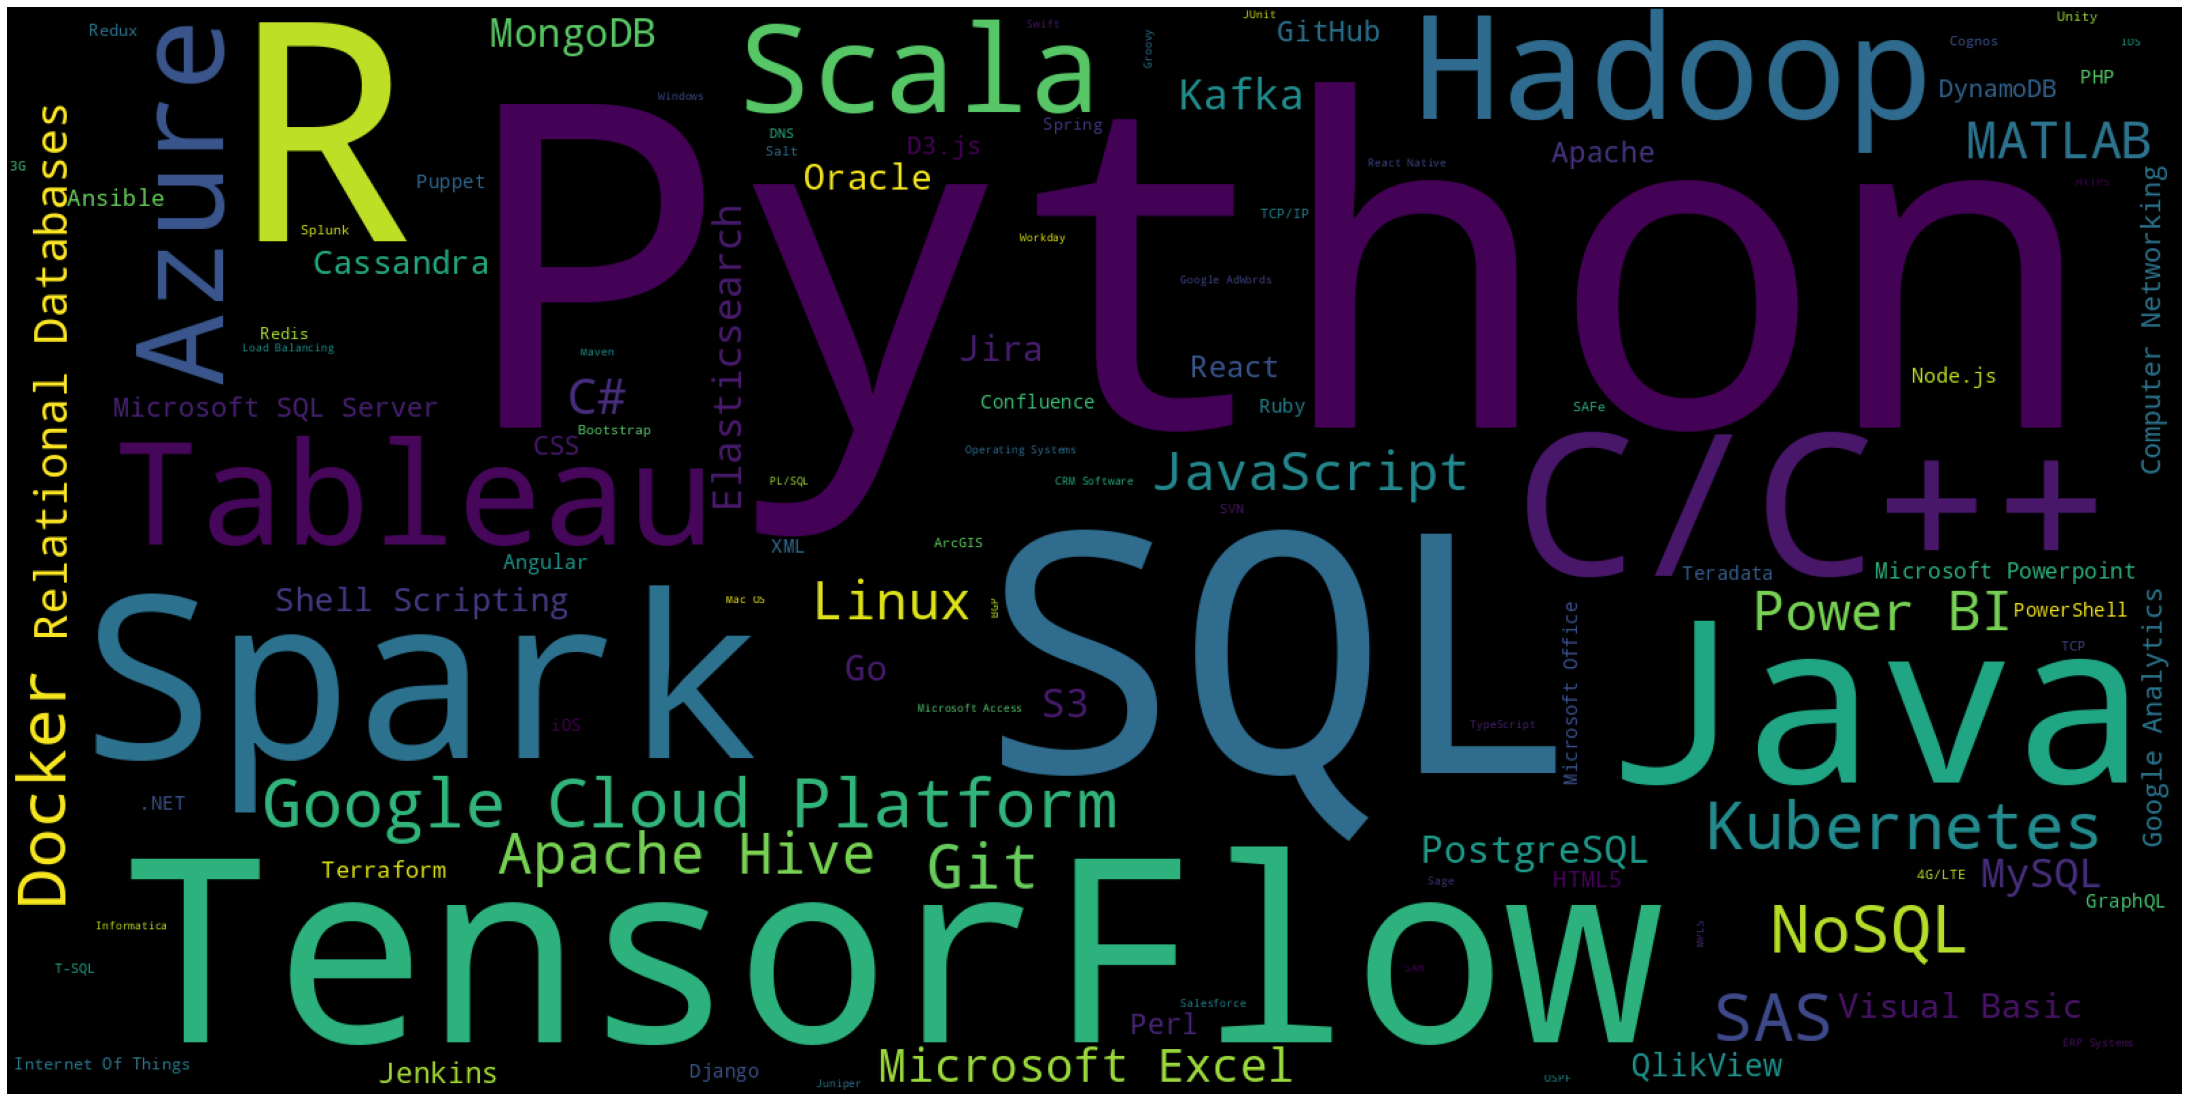

In [262]:
cloud = wordcloud.WordCloud(width=1600, height=800)
cloud.generate_from_frequencies(skill_frequency.to_dict())


plt.tight_layout(pad=0)
plt.figure(figsize=(40,20))
plt.axis('off')
plt.imshow(cloud)

We know from an earlier checks that a skill only exists once per job so where we see 560 for Python we know that there are 560 jobs that contain the skill Python therefore we can calculate the proportion of jobs that contain each skill

In [321]:
skill_frequency[:20] / df_job_details.shape[0] * 100

Python                   67.878788
SQL                      32.484848
R                        27.030303
TensorFlow               18.181818
Spark                    13.939394
Java                     13.818182
C/C++                    13.454545
Hadoop                   11.393939
Tableau                  11.151515
Azure                     8.000000
Scala                     7.878788
Google Cloud Platform     7.151515
Kubernetes                6.787879
SAS                       6.666667
Docker                    6.545455
NoSQL                     6.424242
Git                       5.575758
Apache Hive               4.727273
Power BI                  4.363636
JavaScript                4.242424
dtype: float64

An impressive 68% of jobs require the Python skill, 32% SQL

## Locations

In [397]:
df_job_details.location.value_counts(normalize=True)[0:30]*100

London                 54.303030
Cambridge               6.909091
Oxford                  3.636364
Manchester              2.181818
Edinburgh               2.060606
Reading                 2.060606
Bristol                 1.696970
Home Based              1.575758
Belfast                 1.575758
Cardiff                 1.454545
Southampton             1.333333
Cheltenham              1.212121
Birmingham              1.090909
Glasgow                 0.969697
West London             0.848485
Leeds                   0.848485
Wokingham               0.484848
Exeter                  0.484848
Nottingham              0.484848
Gibraltar               0.484848
Stevenage               0.484848
Warrington              0.484848
Brentford               0.484848
Huntingdon              0.363636
Liverpool               0.363636
Newcastle upon Tyne     0.363636
Kingston upon Hull      0.363636
Abingdon                0.363636
Salford                 0.363636
Staines-upon-Thames     0.363636
Name: loca

As expected London is the major centre for Data Science jobs, over 54% of the roles found were based here.

Home Based / Remote roles featured higher that I thought they might having a higher proportion than some major cities!

## Job Types

In [428]:
df_job_details.groupby('job_type').agg({'job_id':'count','salary_expectation_average':'mean'})

,job_id,salary_expectation_average
job_type,,
CONTRACT,22,8700.244444
"CONTRACT, PERMANENT",1,NaN
"FULLTIME, CONTRACT",4,36412.833333
"FULLTIME, CONTRACT, PERMANENT",2,25000.000000
"FULLTIME, INTERNSHIP",3,14999.500000
"FULLTIME, PARTTIME",21,50358.961538
"FULLTIME, PARTTIME, PERMANENT",2,NaN
"FULLTIME, PERMANENT",38,44865.384615
"FULLTIME, TEMPORARY",2,31000.000000


In [422]:
df_job_details[df_job_details.job_type == 'FULLTIME, TEMPORARY, CONTRACT']

,job_id,json,title,hiring_organization,location,salary_expectation_average,salary_expectation_range,salary_expectation_per,job_type,skills,job_description_html,job_description
155,70c48f3ed58f83a5,"{'showPopoverItaAsync': True, 'showDynamicSave...",Data Scientist,Sheer Jobs Ltd,Wokingham,157.5,£140 - £175,DAILY,"FULLTIME, TEMPORARY, CONTRACT",[],"b""<p>Data Scientist wanted for special assignm...",Data Scientist wanted for special assignment!W...


## Salary

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed

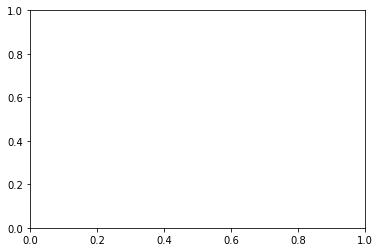

In [414]:
plt.hist(df_job_details.groupby('salary_expectation_per'))

(array([ 33.,  35., 101.,  69.,  39.,  19.,   5.,   3.,   2.,   1.]),
 array([3.89300000e+01, 1.75350370e+04, 3.50311440e+04, 5.25272510e+04,
        7.00233580e+04, 8.75194650e+04, 1.05015572e+05, 1.22511679e+05,
        1.40007786e+05, 1.57503893e+05, 1.75000000e+05]),
 <BarContainer object of 10 artists>)

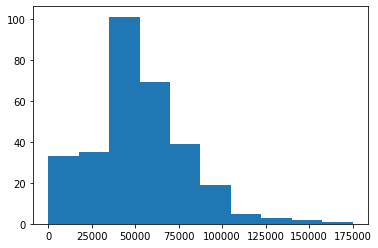

In [411]:
plt.hist(df_job_details.salary_expectation_average.dropna())

In [405]:
df_job_details.salary_expectation_average.mean()

52431.24863192182

In [406]:
df_job_details.salary_expectation_average.median()

50000.0

In [409]:
df_job_details.salary_expectation_per.unique()

[NaN, 'YEARLY', 'DAILY', 'HOURLY', 'WEEKLY', 'MONTHLY']
Categories (5, object): ['YEARLY', 'DAILY', 'HOURLY', 'WEEKLY', 'MONTHLY']